### ORIGINAL FILE PURPOSE: TESTING SCRAPED PUBLIC REPOSITORY AE's
#### Discoveries: many scraped autoencoders, simply dont work/are outdated.
#### Going down a difficulty level to train on 2d images (middle slices) is a very good strategy.. (execution speed++, learning speed++)

In [2]:
# IMPORT EVERYTHING****!!!
#from Architectures.AE_ADJ import AE # for some fucking reason importing this makes it not work? (reconstructs everything around the brain somehow)

from Data.load import load, load_middle_slices
from Visualizations.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
from Visualizations.plots import plot_middle_slices_in_range, plot_models_training_time, compare_models_loss_history, plot_images, compare_models_reconstruction
from Metrics.metrics_tf import MSE_loss, NMSE_loss, NRMSE_loss, SSIM_loss
from Metrics.metrics import NMSE, SSIM, NRMSE, MSE

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from tensorflow.keras import layers, Model, models, Input, activations, regularizers
from skimage.metrics import structural_similarity as ssim

import umap
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import glob
import tensorflow as tf
import tensorflow.keras.backend as K
import time
import math
import nibabel as nib


c:\Users\kiran\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
 # spatially normalized brains were put in this path "\Data\Pre-processed"
take = 350 # max
H_train2D, H_test2D     = load_middle_slices(dataset_name="Pre-processed", axis="sagittal", train_test_split=0.8, take=take)
AD_train2D, AD_test2D   = load_middle_slices(dataset_name="Pre-processed-AD", axis="sagittal", train_test_split=0.8, take=take)
MCI_train2D, MCI_test2D = load_middle_slices(dataset_name="Pre-processed-MCI", axis="sagittal", train_test_split=0.8, take=take)

H_train3D, H_test3D     = load(dataset_name="Pre-processed", train_test_split=0.8, take=take)
AD_train3D, AD_test3D   = load(dataset_name="Pre-processed-AD", train_test_split=0.8, take=take)
MCI_train3D, MCI_test3D = load(dataset_name="Pre-processed-MCI", train_test_split=0.8, take=take)

H_2D = np.concatenate([H_train2D, H_test2D], axis=0)
AD_2D = np.concatenate([AD_train2D, AD_test2D], axis=0)
MCI_2D = np.concatenate([MCI_train2D, MCI_test2D], axis=0)

H_3D = np.concatenate([H_train3D, H_test3D], axis=0)
AD_3D = np.concatenate([AD_train3D, AD_test3D], axis=0)
MCI_3D = np.concatenate([MCI_train3D, MCI_test3D], axis=0)

#A, B = load(dataset_name="Pre-processed-AD", take=30, train_test_split=0.8)
#C, D = load(dataset_name="Pre-processed-MCI", take=30, train_test_split=0.8)
# print(train3d.shape, test3d.shape)
# print(A.shape, B.shape)
# print(C.shape, D.shape)
# AD  = np.concatenate([A, B], axis=0)
# MCI = np.concatenate([C, D], axis=0)
# H   = np.concatenate([train, test], axis=0)

Loading Pre-processed-MCI: 100%|██████████| 46/46 [00:13<00:00,  3.42it/s]


In [59]:
# from ...DementiaMRI.Architectures.VAE import VAE
#from Data.load import load
#from Architectures.latent_space_projections import pPCA, pTSNE, pUMAP, pISOMAP, pENCODED, plot_multiple_datasets
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
import umap
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from Metrics.metrics import NMSE, SSIM, NRMSE
import glob

import tensorflow as tf
from tensorflow.keras import layers, Model, models, Input, activations, regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

from skimage.metrics import structural_similarity as ssim

import time
import math
import nibabel as nib

# TODO: Add skip connections

class AE(Model):
    def __init__(self, 
                input_shape, 
                latent_dim, 
                encoder_layers, 
                decoder_layers, 
                name="AE", 
                loss="mse", #of any other funciton
                learning_rate=1e-3,
                VAE_model=False,
                debug=False,
                GPU = False):
        super(AE, self).__init__(name=name)
        self.loss = loss
        self.learning_rate = learning_rate
        self.input_shape = input_shape
        self.latent_dim = latent_dim
        self.encoder_layers = encoder_layers
        self.decoder_layers = decoder_layers
        self.VAE_model = VAE_model
        self.history = None
        self.debug = debug
        self.GPU = GPU
        self.compile_model()
    
    def compile_model(self):
        """
        Compile the model by iterating through the provided layers and adding them to the Functional API model.
        """
        # Ensure TensorFlow is using the GPU
        #physical_devices = tf.config.list_physical_devices('GPU')
        for device in tf.config.list_physical_devices('GPU'):
            tf.config.experimental.set_memory_growth(device, True)

        # if len(physical_devices) > 0:
            #tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
        if len(self.input_shape) == 4: 
            self.input_shape = (list(self.input_shape) + [1])[-4:] # (8, 80, 96, 80) -> [8, 80, 96, 80, 1] -> [80, 96, 80, 1] 
        if len(self.input_shape) == 3:
            self.input_shape = (list(self.input_shape) + [1])[-3:] # (8, 80, 96) -> [8, 80, 96, 1] -> [80, 96, 1] 
        print(f"Interpreted image shape: {tuple(self.input_shape)}", end=" ")

        # 1. Build the encoder model
        input_layer = x = Input(shape=self.input_shape, name="input")
        x = self.add_layers(x, self.encoder_layers)

        # - Flatten the latent space (encoding output)
        print(f"Pre-flattened latent shape: {x.shape}")
        pre_flatten_shape = x.shape
        x = layers.Flatten()(x)

        # VAE specific: Output mean and log variance
        if self.VAE_model:
            self.mean = layers.Dense(self.latent_dim, name="mean")(x)
            self.log_var = layers.Dense(self.latent_dim, name="log_var")(x)
            z = layers.Lambda(self.sampling, name="z")([self.mean, self.log_var])
            self.encoder = Model(input_layer, [self.mean, self.log_var, z], name="encoder")
        else:
            x = layers.Dense(self.latent_dim, activation="leaky_relu")(x)
            self.encoder = Model(input_layer, x, name="encoder")

        # 2. Build the decoder model
        latent_input = x = layers.Input(shape=(self.latent_dim,)) 

        # Reshape the latent vector back to the original spatial dimensions
        x = layers.Dense(np.prod(pre_flatten_shape[1:]), activation="leaky_relu")(latent_input)
        x = layers.Reshape(pre_flatten_shape[1:])(x)
        x = self.add_layers(x, self.decoder_layers)
        
        self.decoder = Model(latent_input, x, name="decoder")

        # 3. Combine the encoder and decoder into a full VAE
        if self.VAE_model:
            mean, log_var, z = self.encoder(input_layer)
            autoencoder_output = self.decoder(z)
        else:
            autoencoder_output = self.decoder(self.encoder(input_layer))

        # 3. Combine the encoder and decoder into a full autoencoder
        self.autoencoder = Model(input_layer, autoencoder_output, name="autoencoder")
        
        # 4. GPU or CPU assignment (based on self.GPU)
        optimizer = Adam(learning_rate=self.learning_rate)
        loss_fn = self.vae_loss if self.VAE_model else self.loss
        
        with tf.device('/GPU:0' if self.GPU and tf.config.list_physical_devices('GPU') else '/CPU:0'):
            self.autoencoder.compile(optimizer=optimizer, loss=loss_fn)

    def add_layers(self, x, layers):
        for layer in layers:
            
            if isinstance(layer, tuple):
                layer_type, *layer_args = layer
                layer_kwargs = layer_args.pop() if isinstance(layer_args[-1], dict) else {}
                x = layer_type(*layer_args, **layer_kwargs)(x)
            else:
                x = layer(x)
        
            if self.debug:
                print(f"After {x.shape}: {layer}")
        return x

    def summary(self):
        """Print a summary of the neural network model."""
        if self.autoencoder is None:
            raise ValueError("The model is not compiled yet. Call `compile_model()` first.")
        self.autoencoder.summary()
    
    def train(self, x_train, epochs=2, batch_size=16, verbose=False, save_path="", save_interval=100):
        start_time = time.time()        
        
        if save_path:
            os.makedirs(save_path, exist_ok=True)

        # No reason to delete the loss history, if we stopped the sim at epoch10,
        # then we can continue it at another point
        if not hasattr(self, "history") or not self.history:
            #self.history = tf.keras.callbacks.History()  # Ensure history is initialized
            #self.history.history = {"loss": [], "val_loss": []}
            self.history = {"loss": [], "val_loss": []}

        if self.GPU and tf.config.experimental.list_physical_devices('GPU'):
            print(f"Training {self.name} on the GPU", end="")
            with tf.device('/GPU:0'):
                for epoch in range(1, epochs + 1):
                    history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                    )
                    # self.history.history["loss"].extend(history.history["loss"])
                    # self.history.history["val_loss"].extend(history.history["val_loss"])
                    self.history["loss"].extend(history.history["loss"])
                    self.history["val_loss"].extend(history.history["val_loss"])

                    if save_path and epoch % save_interval == 0:
                        self.save(save_path, name=f"{self.name}_epoch{epoch}")
        else:
            print(f"Training {self.name} on the CPU", end="")
            print(type(self.autoencoder), x_train.shape)
            for epoch in range(1, epochs + 1):
                history = self.autoencoder.fit(
                        x_train, x_train,
                        epochs=1,
                        batch_size=batch_size,
                        shuffle=True,
                        validation_split=0.2,
                        verbose=verbose
                )
                #self.history.history["loss"].extend(history.history["loss"])
                #self.history.history["val_loss"].extend(history.history["val_loss"])
                self.history["loss"].extend(history.history["loss"])
                self.history["val_loss"].extend(history.history["val_loss"])
                if save_path and epoch % save_interval == 0:
                    self.save(save_path, name=f"{self.name}_epoch{epoch}")
        
        self.training_time = time.time() - start_time
        print(f" - {round(self.training_time, 2)}s")
        return self.history

    def vae_loss_old(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""
        reconstruction_loss = self.loss(y_true, y_pred)

        # KL divergence loss
        # mean, log_var = self.encoder.input
        kl_loss = -0.5 * K.sum(1 + self.log_var - K.square(self.mean) - K.exp(self.log_var), axis=-1)

        # kl_loss = -0.5 * K.mean(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)
    
    def vae_loss(self, y_true, y_pred):
        """Compute the VAE loss (reconstruction loss + KL divergence loss)."""

        # Reconstruction loss (SSIM loss)
        reconstruction_loss = self.loss(y_true, y_pred)

        # Extract mean and log variance from the encoder's output
        mean, log_var, _ = self.encoder(y_true)  # Use actual values, not placeholders

        # KL divergence loss
        kl_loss = -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis=-1)

        # Total loss
        return K.mean(reconstruction_loss + kl_loss)

    def sampling(self, args):
        mean, log_var = args
        epsilon = K.random_normal(shape=K.shape(mean), mean=0., stddev=1.)
        return mean + K.exp(0.5 * log_var) * epsilon
    
    def sample(self, mean, log_var):
        """Sample from the latent space distribution using the reparameterization trick."""
        # Reparameterization trick
        epsilon = tf.random.normal(shape=tf.shape(mean))  # Sample epsilon from N(0, 1)
        z = mean + tf.exp(0.5 * log_var) * epsilon  # Reparameterization
        return z

    def plot_evaluation(self):
        """Plot the training and validation accuracy/loss over epochs using training logs."""
        pd.DataFrame(self.history).plot(figsize=(8, 5))
        plt.ylabel("")
        plt.xlabel("Epoch")
        plt.grid(True)
        plt.show()

    def encode(self, x):
        """Encode input data x into its latent space representation."""
        return self.encoder.predict(x)

    def decode(self, y):
        """Decode latent space representation y into the original data space."""
        return self.decoder.predict(y)

    def save(self, path, name="AE"):
        """Save the autoencoder, encoder, and decoder models to disk."""
        os.makedirs(path, exist_ok=True)
        self.autoencoder.save(os.path.join(path, f"{name}_autoencoder.keras"))
        self.encoder.save(os.path.join(path, f"{name}_encoder.keras"))
        self.decoder.save(os.path.join(path, f"{name}_decoder.keras"))
        print(f"Models saved to {path} as '{name}_autoencoder.keras', '{name}_encoder.keras', '{name}_decoder.keras'.")

    @staticmethod
    def open(autoencoder_path):
        """Load the autoencoder, encoder, and decoder models from disk using a single path."""
        if not os.path.exists(autoencoder_path):
            raise FileNotFoundError(f"Could not find autoencoder model at {autoencoder_path}.")

        path, autoencoder_filename = os.path.split(autoencoder_path)
        name = autoencoder_filename.replace("_autoencoder.keras", "")

        encoder_path = os.path.join(path, f"{name}_encoder.keras")
        decoder_path = os.path.join(path, f"{name}_decoder.keras")

        if not (os.path.exists(encoder_path) and os.path.exists(decoder_path)):
            raise FileNotFoundError(f"Could not find encoder or decoder models in {path}.")


        autoencoder = tf.keras.models.load_model(autoencoder_path, custom_objects={"MSE_loss": MSE_loss})
        encoder = tf.keras.models.load_model(encoder_path)
        decoder = tf.keras.models.load_model(decoder_path)

        # Create an instance of AE without initializing
        ae = AE.__new__(AE)
        ae.autoencoder = autoencoder
        ae.encoder = encoder
        ae.decoder = decoder

        # Set required attributes
        ae.name = name
        ae.built = True
        ae.history = None
        ae.debug = False

        # Compile the loaded model manually
        ae.autoencoder.compile(optimizer='adam')

        print("Models loaded and compiled successfully.")
        return ae

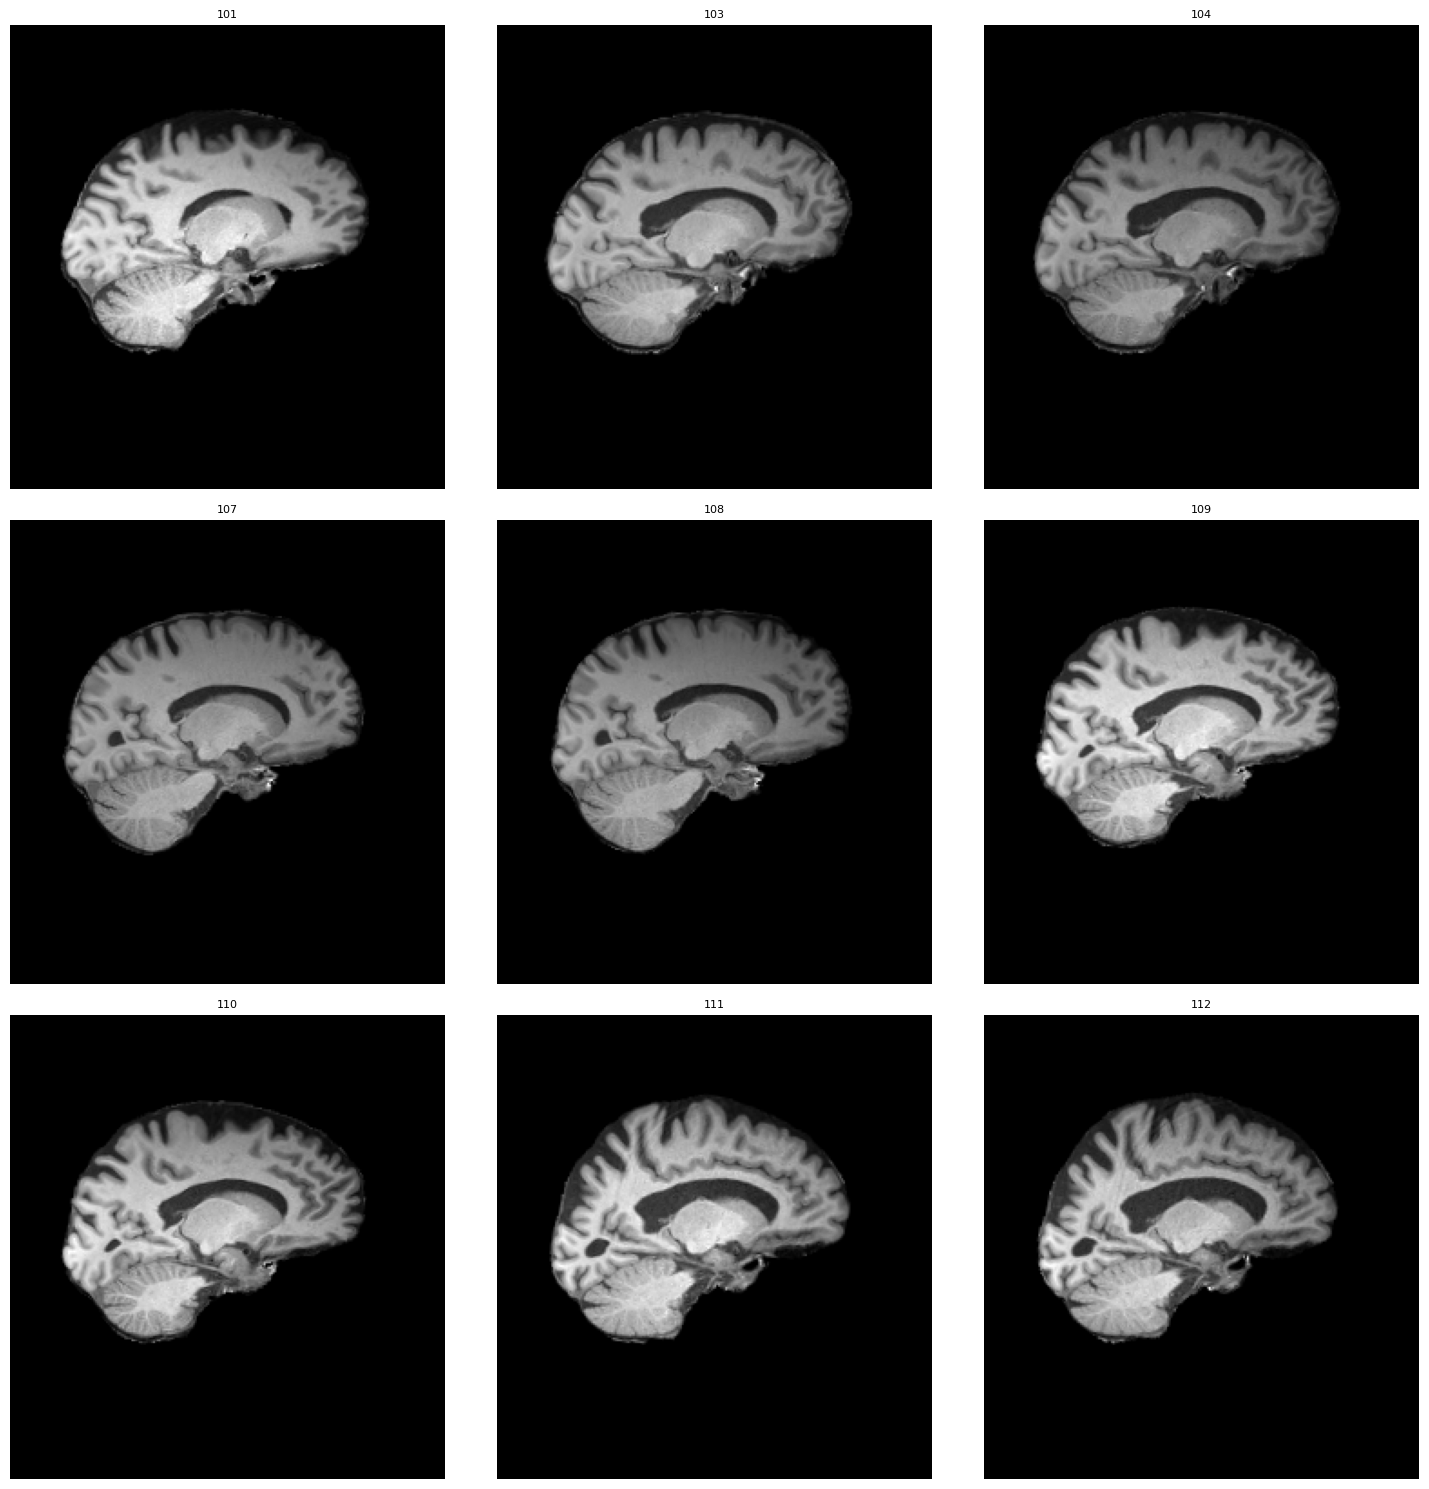

In [36]:
plot_middle_slices_in_range(r"C:\Users\kiran\Documents\_UIS\sem6\BACH\DementiaMRI\Data\Pre-processed", 0, 9)

In [ ]:
A = AE(name="A", input_shape=H_train3D.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 16, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), # layers.BatchNormalization(), layers.LeakyReLU(),
        (layers.Conv3D, 32, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), # layers.BatchNormalization(), layers.LeakyReLU(),
        (layers.Conv3D, 64, (3,3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), # layers.BatchNormalization(), layers.LeakyReLU()
    ],
    decoder_layers=[
        # decoder.append(Conv2DTranspose(filters=filters, kernel_size=5, strides=2, padding='same', name=f'dec_Conv2DT_{i}'))
        # decoder.append(BatchNormalization() if use_batchnorm else LayerNormalization([1, 2]))
        # decoder.append(LeakyReLU())
        (layers.Conv3D, 64, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 32, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 16, (3,3,3), {'padding': 'same'}), (layers.UpSampling3D, (2,2,2)),
        (layers.Conv3D, 1, (3,3,3), {'padding': 'same'}),
        # decoder.append(Conv2DTranspose(filters=filters, kernel_size=5, strides=2, padding='same', name=f'dec_Conv2DT_{i}'))
        # decoder.append(BatchNormalization() if use_batchnorm else LayerNormalization([1, 2]))
        # decoder.append(LeakyReLU())
    ], VAE_model=False, loss=SSIM_loss)

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 10, 12, 10, 64)


In [5]:
"""
C = AE(name="C", input_shape=train2d.shape, latent_dim=128,
       encoder_layers=[
        (layers.Conv2D, 16, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(alpha=0.2),
        (layers.Conv2D, 32, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(alpha=0.2),
        # Encoder Layer 3 (with residual skip connection)
        (layers.Conv2D, 64, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(alpha=0.2),
        # Encoder Layer 4 (optional deepening of the encoder)
        #(layers.Conv2D, 128, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(alpha=0.2),
    ],
    decoder_layers=[
        #(layers.Conv2DTranspose, 128, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(),
        (layers.Conv2DTranspose, 64, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(),
        (layers.Conv2DTranspose, 32, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(),
        (layers.Conv2DTranspose, 16, (3, 3), {'strides': 2, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(),
        #(layers.Conv2D, 64, (3, 3), {'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(), (layers.UpSampling2D, (2, 2)),
        #(layers.Conv2D, 32, (3, 3), {'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(), (layers.UpSampling2D, (2, 2)),
        #(layers.Conv2D, 16, (3, 3), {'padding': 'same'}), layers.BatchNormalization(), layers.LeakyReLU(), (layers.UpSampling2D, (2, 2)),
        (layers.Conv2D, 1,  (3, 3), {'padding': 'same'}),
    ], VAE_model=False, loss=SSIM_loss
)
B = AE(name="Best model", input_shape=train2d.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        #(layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        #(layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=True, loss=SSIM_loss)

C = AE(name="C", input_shape=train2d.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=True, loss=SSIM_loss)
"""

"""
D = AE(name="D", input_shape=train2d.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv2D, 4, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 8, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 8, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 4, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=False, loss=SSIM_loss)
"""

"""
E = AE(name="E", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (5,5), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 128,(3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 128, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 64,  (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 32,  (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1,   (3,3), {'padding': 'same'}),
    ],VAE_model=True, loss=SSIM_loss)
"""

A1 = AE(name="A1", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'relu'}), layers.BatchNormalization(),
    ],
    decoder_layers=[
        (layers.Conv2D, 128, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 64,  (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 32,  (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1,   (3,3), {'padding': 'same'}),
    ],
    VAE_model=True,
    loss=SSIM_loss
)




Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 10, 12, 128)



In [6]:
A2 = AE(name="A2", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        #(layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        #(layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=True, loss=SSIM_loss)



Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 40, 48, 16)


In [209]:
B = AE(name="Best model 2", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 4, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
        #(layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu'}),
    ],
    decoder_layers=[
        #(layers.Conv2D, 32, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 4, (3,3), {'padding': 'same'}), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ], VAE_model=True, loss=SSIM_loss)


Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 40, 48, 4)


In [199]:
from tensorflow.keras import regularizers

B2 = AE(name="Best model B2", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu',
                                    'kernel_regularizer': regularizers.L2(0.001)}),
        #(layers.Conv2D, 16, (3,3), {'strides': 2, 'padding': 'same', 'activation': 'leaky_relu',
        #                            'kernel_regularizer': regularizers.L2(0.001)}),
    ],
    decoder_layers=[
        #(layers.Conv2D, 32, (3,3), {'padding': 'same', 'kernel_regularizer': regularizers.L2(0.001)}), 
        #(layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 16, (3,3), {'padding': 'same', 'kernel_regularizer': regularizers.L2(0.001)}), 
        (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same', 'kernel_regularizer': regularizers.L2(0.001)}),
    ], VAE_model=True, loss=SSIM_loss)


Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 40, 48, 32)


In [ ]:
E = AE(name="E", input_shape=train2d.shape, latent_dim=128,
    encoder_layers=[
        layers.Flatten(), 
        layers.Dense(512), layers.ReLU(),
        layers.Dense(256), layers.ReLU(),
        #layers.Dense(128), layers.ReLU(),  # Latent space
    ],
    decoder_layers=[
        layers.Dense(256), layers.ReLU(),
        layers.Dense(512), layers.ReLU(),
        layers.Dense(np.prod(train2d.shape[1:])), layers.ReLU(),
        layers.Reshape(train2d.shape[1:])  # Reshape to original dimensions
    ], 
    VAE_model=True, loss=SSIM_loss)


In [8]:
A4 = AE(name="latent_dim=16 wtf", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3, 3), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=SSIM_loss)

A5 = AE(name="latent_dim=128 wtf", input_shape=H_train2D.shape, latent_dim=64,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3, 3), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=SSIM_loss)


Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)
Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)


In [20]:
A6 = AE(name="latent_dim=16", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3, 3), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=MSE_loss)

Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)


In [18]:
A6 = AE(name="latent_dim=128", input_shape=H_train3D.shape, latent_dim=128,
    encoder_layers=[
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling3D, {'pool_size': (2, 2, 2)}),
        (layers.Conv3D, 128, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 128, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 64, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv3D, 32, (3, 3, 3), {'activation': 'leaky_relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling3D, {'size': (2, 2, 2)}),
        (layers.Conv3D, 1, (3, 3, 3), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=MSE_loss)

Interpreted image shape: (80, 96, 80, 1) Pre-flattened latent shape: (None, 20, 24, 20, 128)


In [24]:
A7 = AE(name="A7", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3, 3), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=MSE_loss)

Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)


In [ ]:
A8 = AE(name="A8", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, {'pool_size': (2, 2)}),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 128, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization()
    ],
    decoder_layers=[
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 64, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(),
        (layers.Conv2D, 32, (3, 3), {'activation': 'relu', 'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, {'size': (2, 2)}),
        (layers.Conv2D, 1, (3, 3), {'activation': 'sigmoid', 'padding': 'same'})
    ],
    VAE_model=False, loss=MSE_loss)

Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 20, 24, 128)


In [ ]:
A9 = AE(name="A9", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(), (layers.MaxPooling2D, (3,3), {'strides': 2, 'padding': 'same'}),
        (layers.Conv2D, 64, (3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(), (layers.MaxPooling2D, (3,3), {'strides': 2, 'padding': 'same'}),
        (layers.Conv2D, 128, (3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(), (layers.MaxPooling2D, (3,3), {'strides': 2, 'padding': 'same'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 128, (3,3), {'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 64, (3,3), {'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), layers.BatchNormalization(), layers.ReLU(), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ],
    VAE_model=False, loss=MSE_loss)

Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 10, 12, 128)


In [74]:
A9 = AE(name="A9", input_shape=H_train2D.shape, latent_dim=16,
    encoder_layers=[
        (layers.Conv2D, 32, (3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, (3,3), {'strides': 2, 'padding': 'same'}),
        (layers.Conv2D, 64, (3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, (3,3), {'strides': 2, 'padding': 'same'}),
        (layers.Conv2D, 128, (3,3), {'strides': 1, 'padding': 'same'}), layers.BatchNormalization(), (layers.MaxPooling2D, (3,3), {'strides': 2, 'padding': 'same'}),
    ],
    decoder_layers=[
        (layers.Conv2D, 128, (3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 64, (3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 32, (3,3), {'padding': 'same'}), layers.BatchNormalization(), (layers.UpSampling2D, (2,2)),
        (layers.Conv2D, 1, (3,3), {'padding': 'same'}),
    ],
    VAE_model=False, loss=MSE_loss)

Interpreted image shape: (80, 96, 1) Pre-flattened latent shape: (None, 10, 12, 128)


In [78]:
for m in [A9]: #[A2,A4,A5]
    m.train(H_train2D, epochs=200, batch_size=128, verbose=True, 
    save_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models", 
    save_interval=1000)  # saves every 100 epoch btw

Training A9 on the CPU<class 'keras.src.models.functional.Functional'> (270, 80, 96)
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - loss: 0.0105 - val_loss: 0.0404
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.0105 - val_loss: 0.0403
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 927ms/step - loss: 0.0105 - val_loss: 0.0399
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 982ms/step - loss: 0.0104 - val_loss: 0.0398
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 914ms/step - loss: 0.0105 - val_loss: 0.0388
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 943ms/step - loss: 0.0106 - val_loss: 0.0392
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 901ms/step - loss: 0.0105 - val_loss: 0.0383
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 929ms/step - loss: 0.0105 - val_loss: 0.0377
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 924ms/step - loss: 0.0105 - val_loss: 0.0376
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 918ms/step - loss: 0.0105 - val_loss: 0.0372
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 882ms/step - loss: 0.0105 - val_loss: 0.0368
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 938ms/step - loss: 0.0104 - val_loss: 0.0365
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 889ms/step - loss

In [57]:
E5 = AE.open(autoencoder_path=r"C:\Users\kiran\Documents\_UIS\sem6\BACH\local\models\latent_dim=16 wtf_epoch200_autoencoder.keras")
E5.VAE_model = False
E5.history = {'val_loss': []}

Models loaded and compiled successfully.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(96, 80) (96, 80)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
(96, 80) (96, 80)
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
(96, 80) (96, 80)


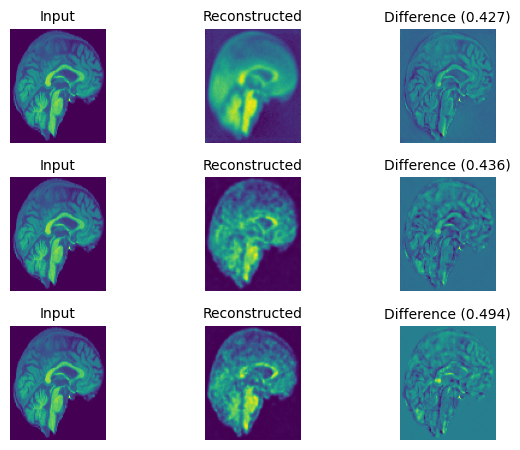

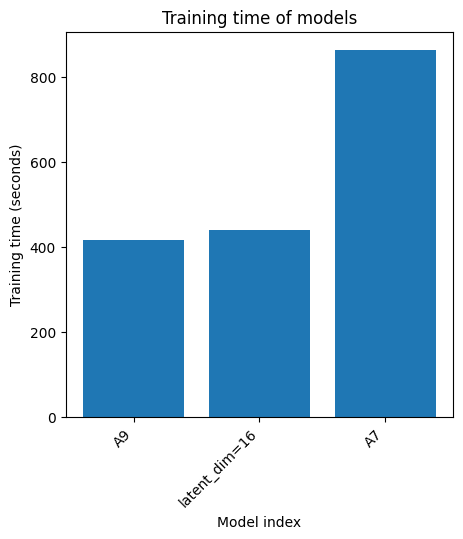

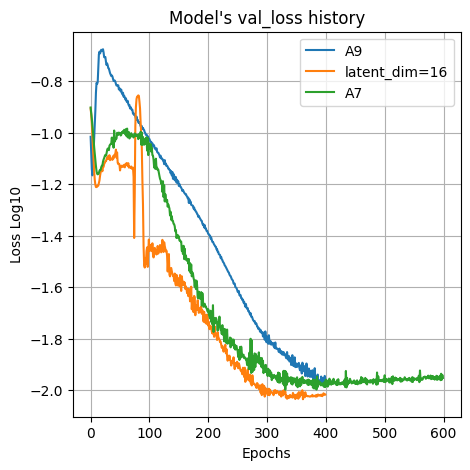

'\nmodels_list3d = [E3]\nmodels_list = models_list3d\n\n\nif \'models_list\' in locals(): # if the variable exists\n    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=H_test3D, loss=SSIM) # remember to update options [test, test2d]\n    #print(latent)\n    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")\n    \n    plot_models_training_time(models_list, fig_size=(5,5))\n    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))\n'

In [82]:
models_list2d = [A9,A6,A7] #[E,E2] #, B0, B1, B2]

models_list = models_list2d

if 'models_list' in locals(): # if the variable exists
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=H_test2D, loss=SSIM) # remember to update options [test, test2d]
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")
    
    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))


"""
models_list3d = [E3]
models_list = models_list3d


if 'models_list' in locals(): # if the variable exists
    images, latent, titles = compare_models_reconstruction(brain_scan_id=0, models_list=models_list, test=H_test3D, loss=SSIM) # remember to update options [test, test2d]
    #print(latent)
    plot_images(images, dimensions=(20,3), fig_size=(6, 30), titles=titles, top_title="")
    
    plot_models_training_time(models_list, fig_size=(5,5))
    compare_models_loss_history(models_list, log10=True, fig_size=(5,5))
"""

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


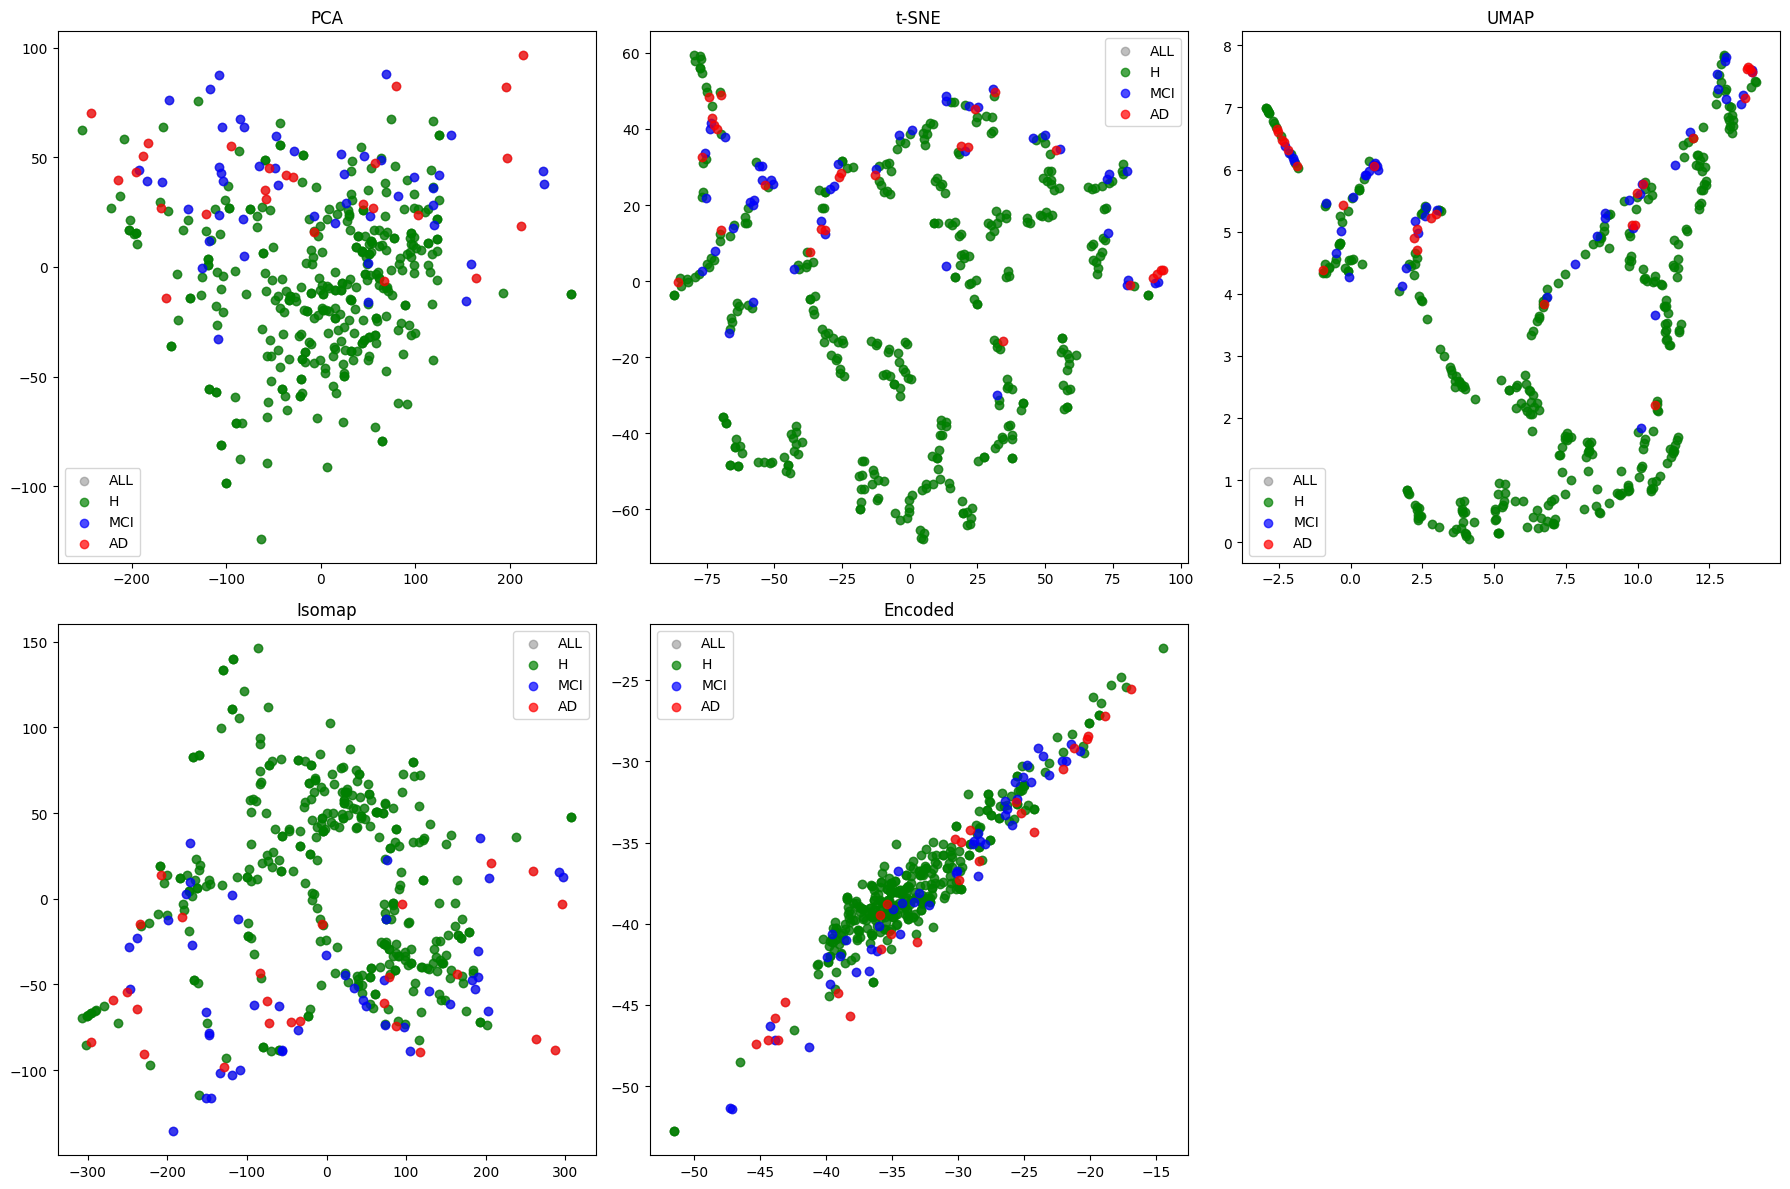

In [80]:
for m in [A9]:
    plot_multiple_datasets( 
        model=m,
        plot_functions=[pPCA, pTSNE, pUMAP, pISOMAP, pENCODED],
        datasets=[H_2D, MCI_2D, AD_2D],
        labels=["H", "MCI", "AD"],
        colors=["green", "blue", "red"],#, "green", "blue"],
        titles=["PCA", "t-SNE", "UMAP", "Isomap", "Encoded"]
    )

11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step


c:\Users\kiran\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step


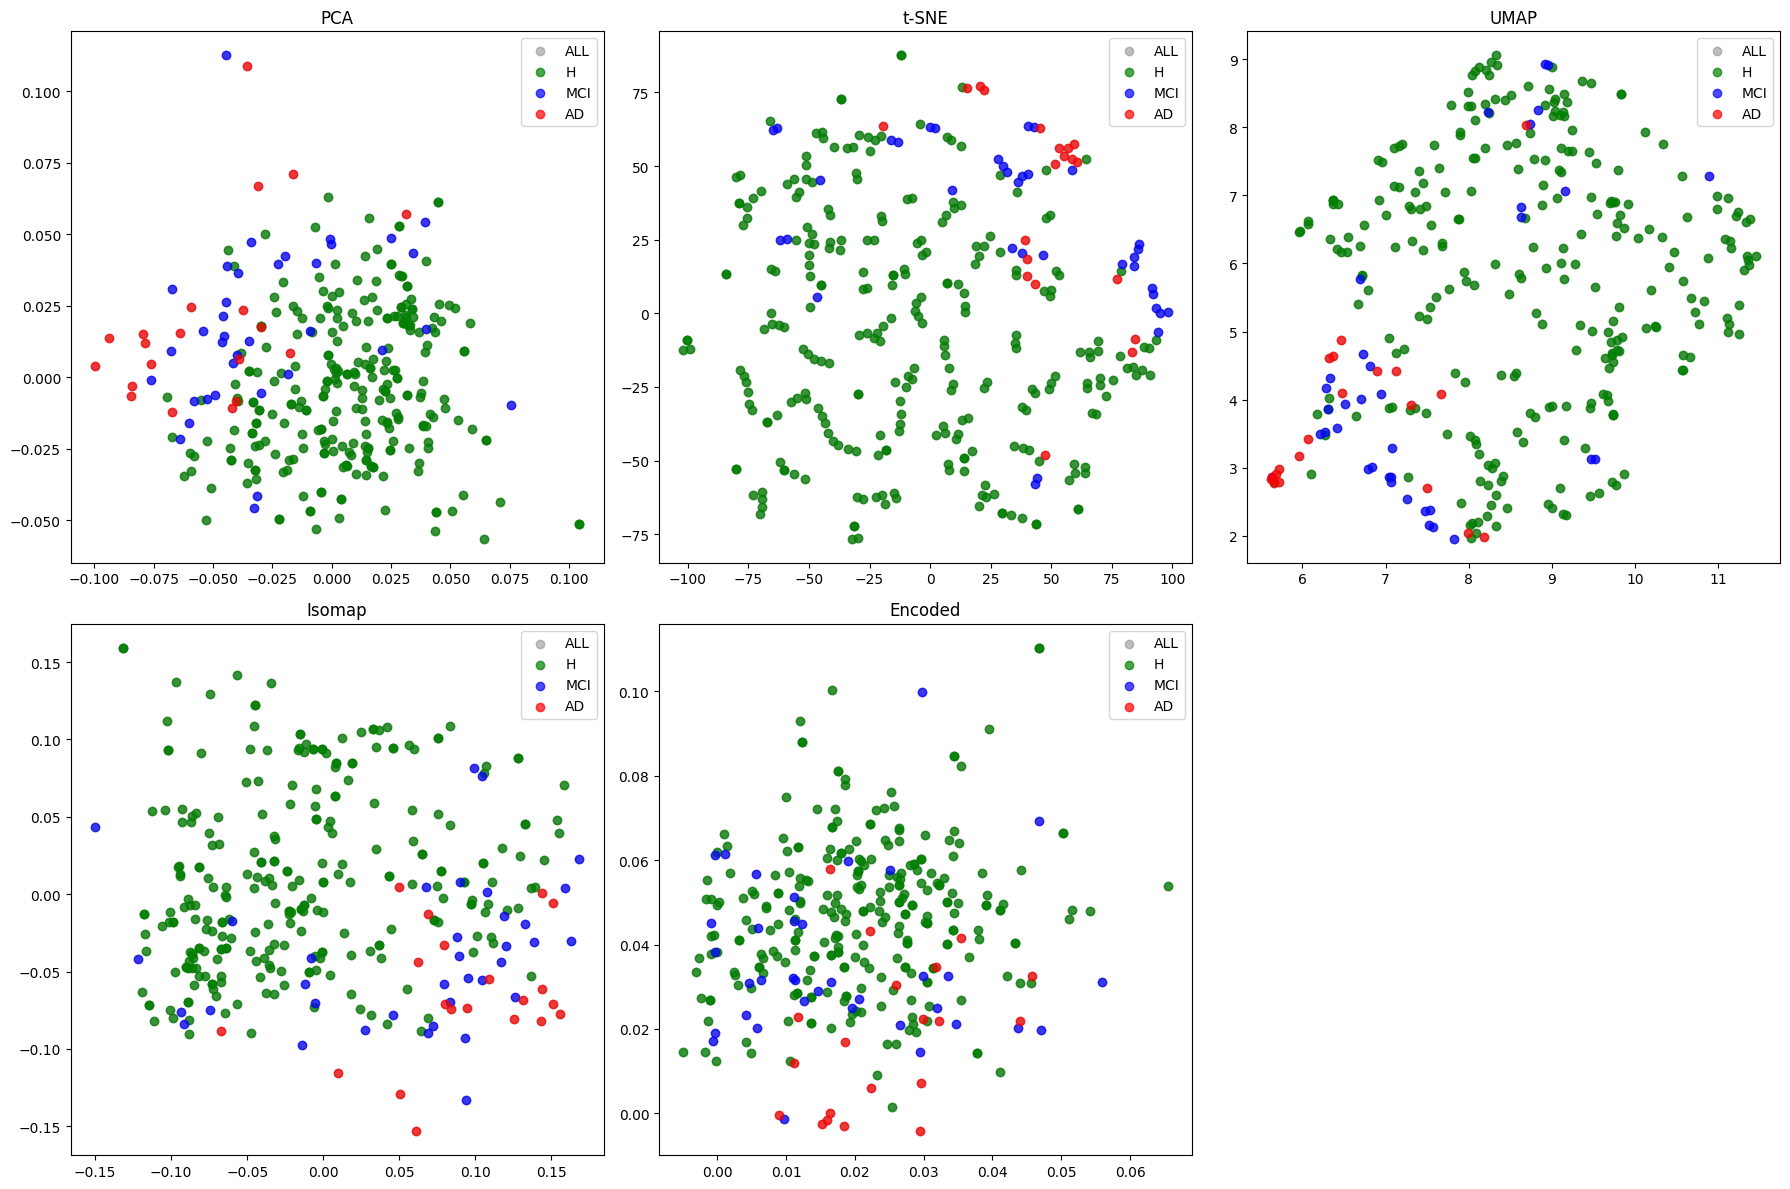

In [61]:
plot_multiple_datasets( 
    model=E4,
    plot_functions=[pPCA, pTSNE, pUMAP, pISOMAP, pENCODED],
    datasets=[H_train2D, MCI_train2D, AD_train2D],
    labels=["H", "MCI", "AD"],
    colors=["green", "blue", "red"],#, "green", "blue"],
    titles=["PCA", "t-SNE", "UMAP", "Isomap", "Encoded"]
)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step 


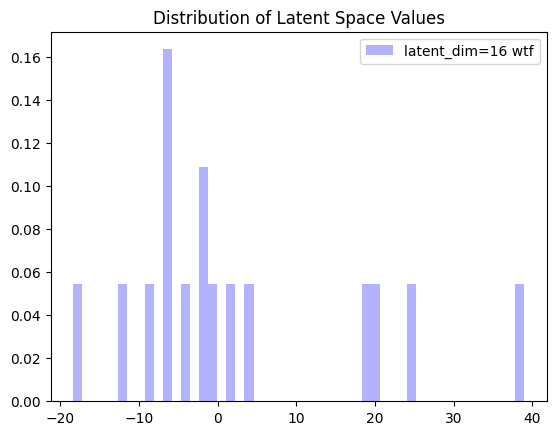

In [33]:
images = []
titles = []
m = E
brain_scan_id = 0 

if m.VAE_model:
    latent = m.encode(H_test2D)[2]
else:            
    latent = m.encode(H_test2D)

import matplotlib.pyplot as plt
import numpy as np

# Assuming `latent_vectors` is your encoded representation
#plt.hist(latent[0].flatten(), bins=50)
plt.hist(latent[0].flatten(), label=E.name, color="blue", alpha=0.3, density=True, bins=50) # Fill
#plt.hist(latent[1].flatten(), label=models_list[1].name, color="red", alpha=0.3, density=True, bins=50) # Fill
plt.title("Distribution of Latent Space Values")
plt.legend()
plt.show()

In [ ]:
input_shape = train2d.shape
if len(input_shape) == 4: 
    input_shape = (list(input_shape) + [1])[-4:] # (8, 80, 96, 80) -> [8, 80, 96, 80, 1] -> [80, 96, 80, 1] 
if len(input_shape) == 3:
    input_shape = (list(input_shape) + [1])[-3:] # (8, 80, 96) -> [8, 80, 96, 1] -> [80, 96, 1] 
print(input_shape)

def SSIM_loss(y_true, y_pred):
    """SSIM loss for both 2D and 3D images"""

    # If the image is 2D (batch_size, height, width)
    if len(y_true.shape) == 3:  # (batch_size, height, width)
        y_true_copy = tf.expand_dims(y_true, axis=-1)  # Add a channel dimension
        y_pred_copy = tf.expand_dims(y_pred, axis=-1)  # Add a channel dimension
        return 1.0 - tf.reduce_mean(tf.image.ssim(y_true_copy, y_pred_copy, max_val=1.0))
    
    # If the image is 3D (batch_size, height, width, depth)
    elif len(y_true.shape) == 4:  # (batch_size, height, width, depth)
        # Compute SSIM for each slice along the depth axis (if depth exists in the last dimension)
        ssim_scores = []
        for i in range(y_true.shape[-1]):  # Loop over the depth dimension
            slice_true = y_true[:, :, :, i]  # Take the i-th slice from y_true
            slice_pred = y_pred[:, :, :, i]  # Take the i-th slice from y_pred
            slice_true = tf.expand_dims(slice_true, axis=-1) # add channel dimension
            slice_pred = tf.expand_dims(slice_pred, axis=-1) # add channel dimension
            #print(slice_true.shape, slice_pred.shape, y_true.shape)
            ssim_score = tf.image.ssim(slice_true, slice_pred, max_val=1.0)
            ssim_scores.append(ssim_score)

        # Average SSIM scores over all slices
        average_ssim = tf.reduce_mean(ssim_scores)
        return 1.0 - average_ssim
    else:
        raise ValueError("Input tensors must be either 3D (for 2D images) or 4D (for 3D images).")

# Example usage for 2D images
y_true_2d = tf.random.normal((3, 96, 80))  # (batch_size, height, width)
y_pred_2d = tf.random.normal((3, 96, 80))
loss_2d = SSIM_loss(y_true_2d, y_pred_2d)
print(loss_2d)

# Example usage for 3D images
y_true_3d = tf.random.normal((3, 96, 80, 10))  # (batch_size, height, width, depth)
y_pred_3d = tf.random.normal((3, 96, 80, 10))
loss_3d = SSIM_loss(y_true_3d, y_pred_3d)
print(loss_3d)

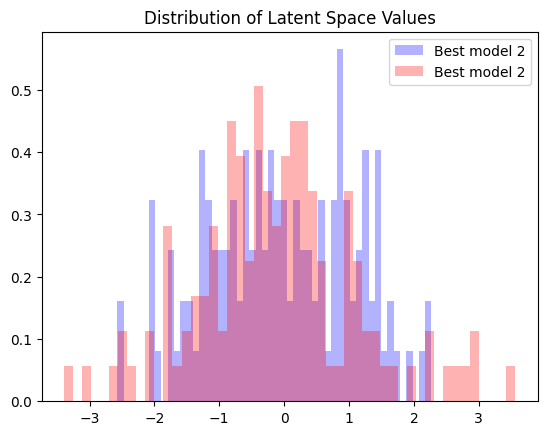

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `latent_vectors` is your encoded representation
#plt.hist(latent[0].flatten(), bins=50)
plt.hist(latent[0].flatten(), label=models_list[0].name, color="blue", alpha=0.3, density=True, bins=50) # Fill
plt.hist(latent[1].flatten(), label=models_list[1].name, color="red", alpha=0.3, density=True, bins=50) # Fill
plt.title("Distribution of Latent Space Values")
plt.legend()
plt.show()